<a href="https://colab.research.google.com/github/ilaydayaman/Bachelor_Thesis/blob/master/ML_course_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# System information

GPU info

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Memory info

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


# Import custom libraries

In [5]:
#upload following files: classes.py, config.py, features.py, graphics.py, 0-weights.data, 0-weights.index
from google.colab import files
#files.upload()

In [6]:
import config as cfg
from classes import Scenario, LIS, Channel, Panel, Point
from features import data_flatten, real_imag
from graphics import plot_scenario, add_scatter, add_plot, save_plot

# Test scenario and channel generation

In [7]:
# Test scenario and channel generation
scenario = Scenario(cfg.WIDTH, cfg.HEIGHT, cfg.DEPTH)

LIS creation:

In [8]:
# LIS creation:
lis = LIS(scenario)
scenario.LIS = lis

Add panel

In [9]:
# Points: (x,y,z)
centre = Point(0, 0, 0)
wall = 'bottom'
panel = Panel(cfg.Mp, cfg.ant_dist, centre, wall, scenario)#wall is redundant (remove it later)
lis.add_panel(panel)

In [10]:
lis.info()

LIS structure summary:
Number of panels: 1
Panel 0:
Panel summary:
-Panel dimensions: (0.40 x 0.40) m
-Panel elements: (8 x 8) = 64
-Centre of the panel: (0.0, 0.0, 0.0)




Select positions for grid and users in the scenario:

In [11]:
# Generate positions in the scenario:
scenario.gen_pos_test(cfg.n_pos_test, 'square')

In [12]:
scenario.info()

SCENARIO:
width: 10.00 m
depth: 10.00 m
height: 3.00 m


In [13]:
#  distance between locations
dist = np.sqrt(np.sum(np.square(np.diff(scenario.pos_test, axis=0)), axis=1))
print("distance between locations (m): ", dist[0])
print("normalized mean distance between locations: ", dist[0]/cfg.wavelength)

distance between locations (m):  0.41025641025641013
normalized mean distance between locations:  4.102564102564101


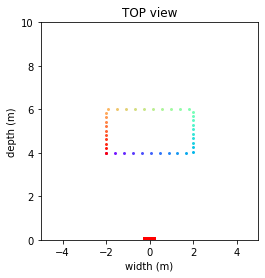

In [14]:
plot_scenario(scenario)
add_scatter(scenario.pos_test, 'rainbow', 2)
save_plot("scenario.eps")

Generate channel for the defined scenario:

In [15]:
c = 3e8
la = cfg.wavelength
fc = c / la
fv = np.linspace(fc - cfg.BW / 2, fc + cfg.BW / 2, num=cfg.Nsc)  # array of frequencies used by one user
lav = c / fv  # array of wavelengths used by one user

In [16]:
# Compute channel for test set
# Different noise seed in testing than in training
cfg.noise_seed = 2
ch = Channel(
  lis=lis,
  scenario=scenario,
  ch_type=cfg.channel,
  freq=fv,
  noise_var=cfg.noise_var,
  noise_seed=cfg.noise_seed,
  ref_coe=cfg.ref_coe)

In [17]:
# Test data
Hp_t, snr_p_t = ch.model(scenario.pos_test)

In [18]:
print ("-------Channel properties-------")
print ("channel type: %.0f" % cfg.channel)
print ("reflection coefficient: %.1f" % cfg.ref_coe)
print ("noise variance: %.5f" % cfg.noise_var)
print ("noise seed: %.0f" % cfg.noise_seed)
print ("channel shape (training set): ", Hp_t.shape)

-------Channel properties-------
channel type: 2
reflection coefficient: 0.1
noise variance: 0.00100
noise seed: 2
channel shape (training set):  (1, 40, 8, 8, 8)


Data preprocessing: Feature extraction

In [19]:
Fp_t = real_imag(Hp_t)
Fp_t = data_flatten(Fp_t)
test_data = Fp_t

In [20]:
print("--------Data ----------")
print("test_data.shape:", test_data.shape)

--------Data ----------
test_data.shape: (1, 40, 1024)


# Model (wireless sensor ML)

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam, RMSprop
tfd = tfp.distributions
tfpl = tfp.layers

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.6.0
TFP version: 0.13.0


Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv3D

#event_shape: number of dimensions in the event space (event_shape=2)
def dnn_model_bayes_aleatoric(event_shape):
  # Create model.
  model = Sequential([
      Dense(200, activation='relu'),
      Dropout(0.2),
      BatchNormalization(),
      Dense(100, activation='relu'),
      Dropout(0.2),
      Dense(20, activation='relu'),
      Dense(tfpl.MultivariateNormalTriL.params_size(event_shape)),
      tfpl.MultivariateNormalTriL(event_shape)
  ])
  return model

Load weights model

In [23]:
p = 0  # panel index
n_dim = 2  # number of dimensions of the location (x,y)
model = dnn_model_bayes_aleatoric(n_dim)
model.load_weights('%d-weights'%p)

# Inference and visualization

In [24]:
#This function plots confident intervals (or ellipses in Gaussian distribution) for the input pdf, and probability prb.
#The pdf argument can be a batch of pdfs, one per location
#With step we can skip locations. Useful for visualization.
def plot_confident_interval(pdf, prb, step=1):
  x_est = pdf.mean()
  x_std = pdf.stddev()
  #
  #prb=0.8  # x% confident level 2D normal distribution
  # B. Wang: "Confidence Analysis of Standard Deviational Ellipse and Its Extension into Higher Dimensional Euclidean Space"
  times_sigma = np.sqrt(-2*np.log(1-prb))
  confident_level = 1./(2*np.pi*tf.math.reduce_prod(x_std,axis=1))*np.exp(-0.5*times_sigma**2)
  #
  x = np.arange(-scenario.width/2.0, scenario.width/2.0, 0.1)
  y = np.arange(0.0, scenario.depth, 0.1)
  X, Y = np.meshgrid(x, y)
  s = np.shape(X)

  Xf, Yf = X.flatten(), Y.flatten()
  D = np.zeros((np.product(s),2))
  #the prob model expects a format like: (depth, width)
  D[:,1] = Xf
  D[:,0] = Yf
  #
  plot_scenario(scenario)
  De = D[:,np.newaxis,:]  # broadcasting to batch axis: (samples, batch, event) = (10000, 1, 2)
  Zf = pdf.prob(De)  # Zf.shape = (10000, n_test)
  #print(Zf.shape)
  Z = tf.reshape(Zf, np.append(s,scenario.n_test))  # Zf.shape = (100, 100, n_test)
  for n in range(0,scenario.n_test,step):
    plt.contour(X,Y,Z[:,:,n],[confident_level[n]])

  #n=0
  #plt.contour(X,Y,Z[:,:,n],[confident_level[n]])

  add_scatter(x_est[::step], 'blue', 10)
  add_scatter(scenario.pos_test[::step], 'red', 10)
  #add_scatter(x_est[tf.newaxis,n].numpy(), 'blue', 10)
  #add_scatter(scenario.pos_test[tf.newaxis,n], 'red', 10)

  #save_plot('dnn_model_bayes_aleatoric_prb08_p%s.pdf'%p)

Inference

In [25]:
p = 0  # panel index
csi = test_data[p,:]
#print(csi.shape)
pdf_sensor = model(csi)  # inference: one pdf per test point

Plot confident intervals (ellipses)

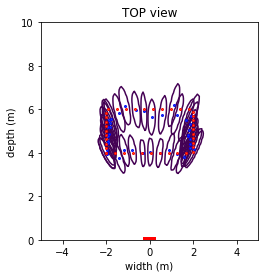

In [26]:
prb = 0.8  # x% confident level 2D normal distribution
plot_confident_interval(pdf_sensor, prb)
#save_plot('dnn_model_bayes_aleatoric_prb08_p%s.pdf'%p)

# Error analysis

In [27]:
pos_est = pdf_sensor.mean()  # point estimate
#print(pos_est.shape)

In [28]:
de = np.linalg.norm(pos_est - scenario.pos_test, axis=1)
MDE = np.mean(de)
SDE = np.std(de)
print("MDE =", MDE, "m")
print("SDE =", SDE, "m")

MDE = 0.21136215 m
SDE = 0.14419436 m


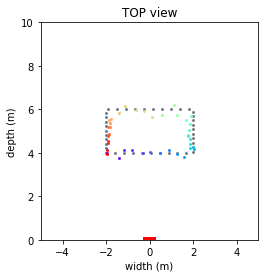

In [29]:
plot_scenario(scenario)
add_scatter(pos_est, 'rainbow', 2)
add_scatter(scenario.pos_test, 'grey', 1)
save_plot("estimation.pdf")

# Tracking

In [30]:
!git clone --depth=1 https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
!pip install filterpy

fatal: destination path 'Kalman-and-Bayesian-Filters-in-Python' already exists and is not an empty directory.


In [31]:
from filterpy.kalman import KalmanFilter as kf 
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from book_plots import plot_measurements
from filterpy.stats import plot_covariance
from book_plots import plot_filter

Initialize the Kalman Filter 

In [32]:
n_dim = 2  # num. dimensions = 2
x = np.zeros((2*n_dim,1))  # Kalman initial state
#P = ...  # initial state covariance
#Q = ...  # process covariance (constant?)
zs = []
Rs = []
for n in range(scenario.n_test):
  #  current location (ground truth)
  csi = test_data[0,n]  # wireless channel for current location
  csi = csi[np.newaxis,:]  # add extra dimension for compatibility
  #---------Wireless sensor reading----------
  pdf_n = model(csi)  # inference: pdf as output of wireless sensor for location index n (pdf as TFP distribution)
  z = pdf_n.mean()[0].numpy()  # measurement mean (sensor) (depth, width) (y, x)
  R = pdf_n.covariance()[0].numpy()  # measurement error covariance (sensor)
  #----------store results------------------
  #zs = np.append(zs, z, axis=0)
  zs.append(z)
  Rs.append(R) #, R, axis=1

In [33]:
Q_std = 0.1
init_pos = pdf_n.mean()[0].numpy() 

Initialize x with sensor measurements 

In [34]:
def trackerFunc():
    tracker = kf(dim_x=4, dim_z=2)
    dt = 1.0  # time step 1s

    # State transition matrix
    tracker.F = np.array([[1, dt, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 1, dt],
                          [0, 0, 0, 1]])

    # process noise is discrete time Weiner process (constant for each time period)
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)

    # measurement function 
    tracker.H = np.array([[1, 0, 0, 0],
                          [0, 0, 1, 0]])
    
    # measurement noise 
    tracker.R = pdf_n.covariance()[0].numpy() # np.eye(2) * R_std**2

    # initial value for the state (position and velocity)
    tracker.x = np.array([[init_pos[0], init_pos[1], 0, 0]]).T

    # Covariance matrix P 
    tracker.P = np.eye(4) * 5.
    return tracker

Run the filter 

In [35]:
zs = np.reshape(zs, (n+1,2))
robot_tracker = trackerFunc()
mu, cov, _, _ = robot_tracker.batch_filter(zs=zs, Rs=Rs)

(<matplotlib.collections.PathCollection at 0x7fc27520bed0>,)

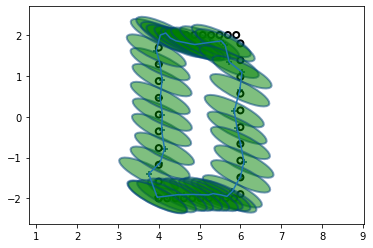

In [36]:
for x, mP in zip(mu, cov):
   # covariance of x and y
    cov = np.array([[robot_tracker.P[0, 0], robot_tracker.P[2, 0]],
                    [robot_tracker.P[0, 2], robot_tracker.P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance(mean, cov=cov, fc='g', std=3, alpha=0.5)
  

# the figure should be transposed but it still gives the idea with sizes of ellipses etc. 
plot_filter(mu[:, 0], mu[:, 2]) # blue line
plot_measurements(scenario.pos_test[:, 0], scenario.pos_test[:, 1]) # black dots 

Plot Results 

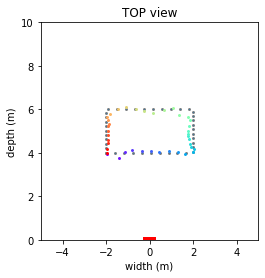

In [37]:
pos_est_KF = np.zeros((len(mu),2))
pos_est_KF = np.concatenate((mu[:, 0], mu[:, 2]), axis=1)

plot_scenario(scenario)
add_scatter(scenario.pos_test, 'grey', 1)
add_scatter(pos_est_KF, 'rainbow', 2)
save_plot("est_result_after_KF.eps")

Calculate MDE & SDE and plot the distance error before and after the Kalman filter

In [38]:
de_KF = np.linalg.norm(pos_est_KF - scenario.pos_test, axis=1)
MDE_KF = np.mean(de_KF) #mean distance errror
SDE_KF = np.std(de_KF) #standard deviation error 
print("MDE =", MDE_KF, "m")
print("SDE =", SDE_KF, "m")

MDE = 0.16476940136422188 m
SDE = 0.13619071091842022 m


Text(0, 0.5, 'distance error(m)')

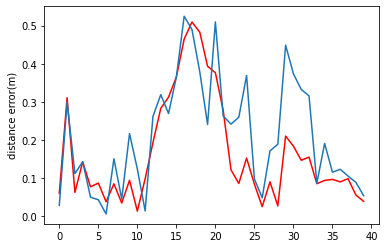

In [39]:
# red line represents the distance error after Kalman filter 
plt.plot(de_KF, 'r', de)
plt.ylabel('distance error(m)')